# Age and Gender Detection System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

# Configuring Kaggle API
By generating API token to be inserted below.

In [7]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"janvichoudhary","key":""}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Dowloading UTKFace Dataset[Here!](https://www.kaggle.com/datasets/jangedoo/utkface-new)

In [9]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 323M/331M [00:04<00:00, 43.5MB/s]
100% 331M/331M [00:04<00:00, 83.1MB/s]


In [10]:
!unzip 'utkface-new.zip' -d faces

Streaming output truncated to the last 5000 lines.
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: faces/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflati

Defining path to file and printing its length along with the first 3 file names.

In [21]:
path = Path("/content/faces/UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))


In [22]:
print(len(filenames))
print(filenames[:3])

23708
['70_0_0_20170120225631818.jpg.chip.jpg', '24_0_2_20170116163417424.jpg.chip.jpg', '52_0_0_20170116183903737.jpg.chip.jpg']


# From Unstructured Data to Structured Data
Creating lables for age , gender and image path.

In [23]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

In [24]:
image_path

['72_1_0_20170110180453423.jpg.chip.jpg',
 '50_1_0_20170117174644414.jpg.chip.jpg',
 '26_0_0_20170113210605342.jpg.chip.jpg',
 '35_0_4_20170104181306061.jpg.chip.jpg',
 '26_1_3_20170119193118067.jpg.chip.jpg',
 '24_1_2_20170116172449090.jpg.chip.jpg',
 '26_1_0_20170116184526152.jpg.chip.jpg',
 '26_1_3_20170119193143376.jpg.chip.jpg',
 '35_0_1_20170117000315372.jpg.chip.jpg',
 '77_1_0_20170110122639530.jpg.chip.jpg',
 '86_1_0_20170110183616456.jpg.chip.jpg',
 '4_1_0_20170109191135825.jpg.chip.jpg',
 '26_1_1_20170112213133100.jpg.chip.jpg',
 '27_0_3_20170119155943666.jpg.chip.jpg',
 '42_0_0_20170113184535624.jpg.chip.jpg',
 '26_1_3_20170119192844345.jpg.chip.jpg',
 '35_0_0_20170116233057278.jpg.chip.jpg',
 '25_1_0_20170117143916425.jpg.chip.jpg',
 '34_0_0_20170117105018453.jpg.chip.jpg',
 '20_0_1_20170113132756615.jpg.chip.jpg',
 '32_0_0_20170104202215275.jpg.chip.jpg',
 '31_0_1_20170116220207245.jpg.chip.jpg',
 '56_0_0_20170104212000007.jpg.chip.jpg',
 '27_0_0_20170104231544105.jpg.chip

In [34]:
df = pd.DataFrame()
df['image'] = image_path
df['age'] = age_labels
df['gender'] = gender_labels

In [36]:
df.head()

,image,age,gender
0,72_1_0_20170110180453423.jpg.chip.jpg,72,1
1,50_1_0_20170117174644414.jpg.chip.jpg,50,1
2,26_0_0_20170113210605342.jpg.chip.jpg,26,0
3,35_0_4_20170104181306061.jpg.chip.jpg,35,0
4,26_1_3_20170119193118067.jpg.chip.jpg,26,1


In [42]:
gender_dict = {0:"Male",1:"Female"}

In [37]:
df = df.astype({'age':'float32', 'gender': 'int32'})

In [38]:
print(df.dtypes)

image      object
age       float32
gender      int32
dtype: object


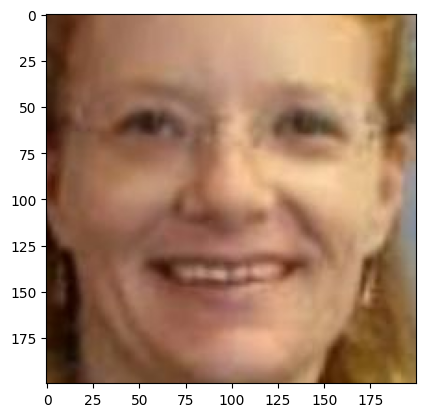

In [39]:
img = Image.open("/content/faces/UTKFace/"+df.image[1])
plt.imshow(img)

<ipython-input-40-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

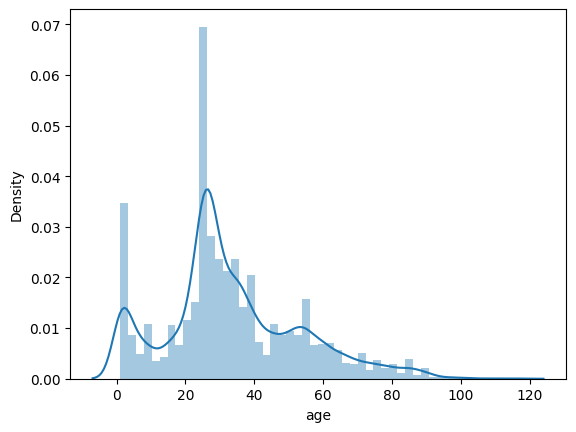

In [40]:
sns.distplot(df.age)

# Plotting images
Along with their age and gender. Then splitting the train and test data.

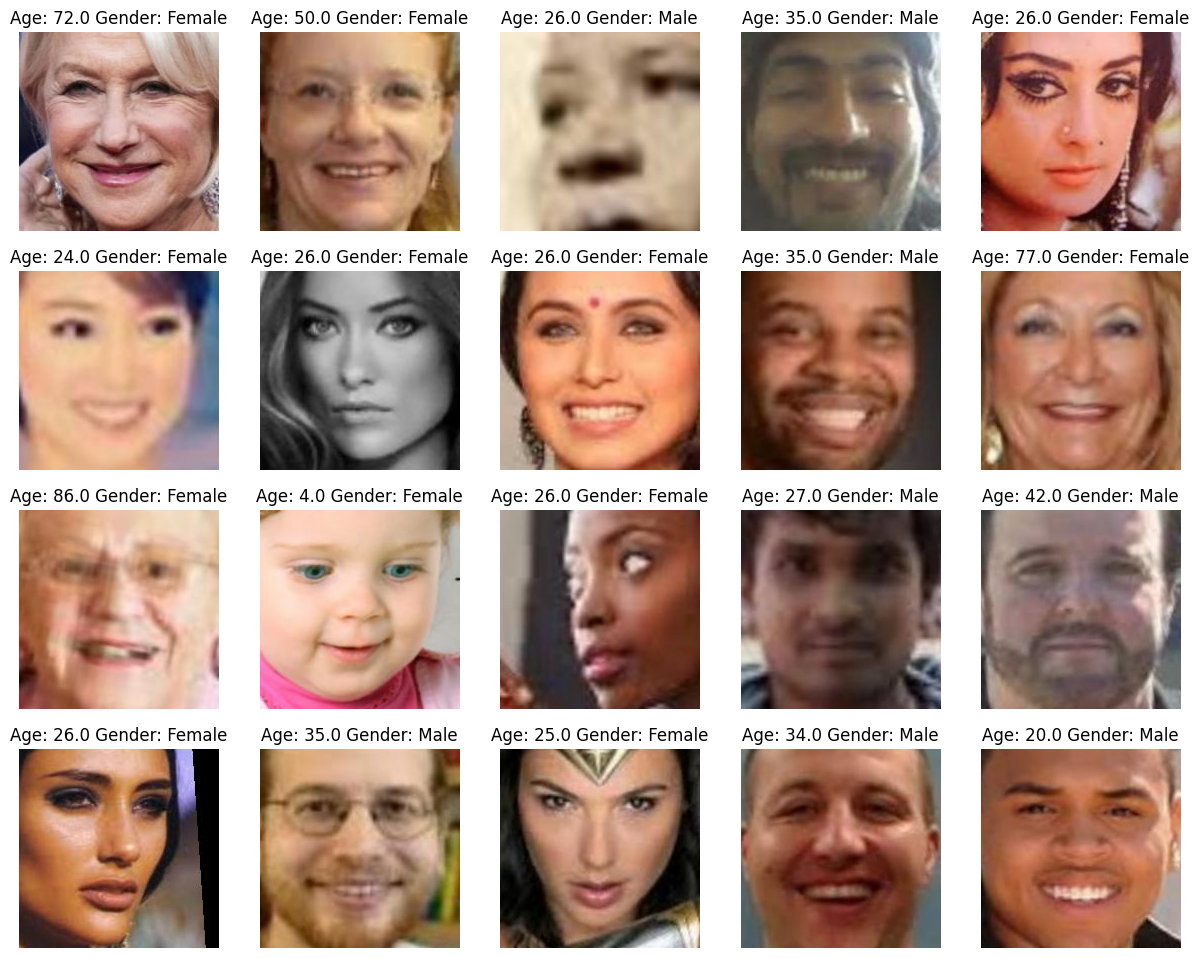

In [43]:
files = df.iloc[0:20]
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/faces/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [44]:
train, test = train_test_split(df, test_size=0.85, random_state=42)

In [45]:
train.head()

,image,age,gender
18199,1_0_2_20161219162427318.jpg.chip.jpg,1.0,0
19557,45_0_0_20170117173032588.jpg.chip.jpg,45.0,0
20132,22_1_2_20170116161424702.jpg.chip.jpg,22.0,1
11849,24_1_1_20170113003543637.jpg.chip.jpg,24.0,1
2100,11_1_3_20170104222911112.jpg.chip.jpg,11.0,1


# Extracting Features

In [47]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/faces/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)

<ipython-input-47-0bbb382201d5>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [48]:
x_train.shape

(3556, 128, 128, 1)

# Normalize Data

In [49]:
x_train = x_train/255

In [50]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)

In [51]:
input_size = (128,128,1)

# Creating Model
Using Convolutional Neural Network but with skip connections. Skip connections are used in Residual NN but here CNN has been implemented with little Skip connections (shortcut).

In [52]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [53]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])

In [54]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

# Training the model

In [55]:
model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)

Epoch 1/20
320/320 [==============================] - 218s 669ms/step - loss: 16.1299 - gender_output_loss: 0.7105 - age_output_loss: 15.4193 - gender_output_accuracy: 0.6566 - age_output_accuracy: 0.0441 - val_loss: 24.6602 - val_gender_output_loss: 0.6132 - val_age_output_loss: 24.0469 - val_gender_output_accuracy: 0.6629 - val_age_output_accuracy: 0.0506
Epoch 2/20
320/320 [==============================] - 216s 676ms/step - loss: 12.5533 - gender_output_loss: 0.5028 - age_output_loss: 12.0505 - gender_output_accuracy: 0.7638 - age_output_accuracy: 0.0341 - val_loss: 11.6707 - val_gender_output_loss: 0.3981 - val_age_output_loss: 11.2726 - val_gender_output_accuracy: 0.8230 - val_age_output_accuracy: 0.0337
Epoch 3/20
320/320 [==============================] - 209s 654ms/step - loss: 11.3563 - gender_output_loss: 0.4228 - age_output_loss: 10.9335 - gender_output_accuracy: 0.8062 - age_output_accuracy: 0.0175 - val_loss: 11.1448 - val_gender_output_loss: 0.3750 - val_age_output_loss:

# Visualizing loss

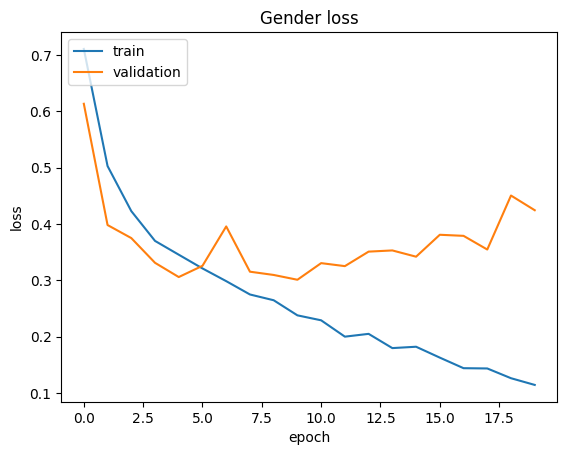

In [56]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

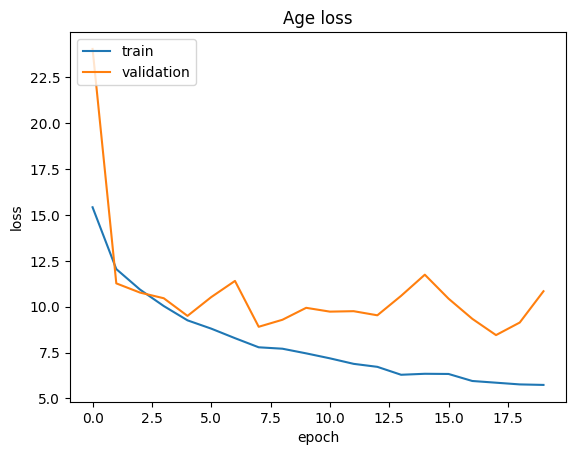

In [57]:
plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predicting test images

Original: Gender =  Female  Age =  45.0
1/1 [==============================] - 0s 411ms/step
Prediction: Gender =  Female  Age =  29


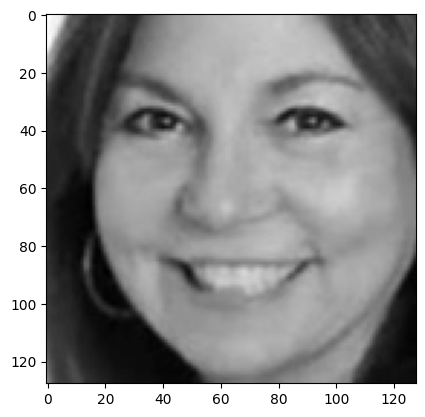

In [58]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')

Original: Gender =  Male  Age =  48.0
1/1 [==============================] - 0s 40ms/step
Prediction: Gender =  Male  Age =  46


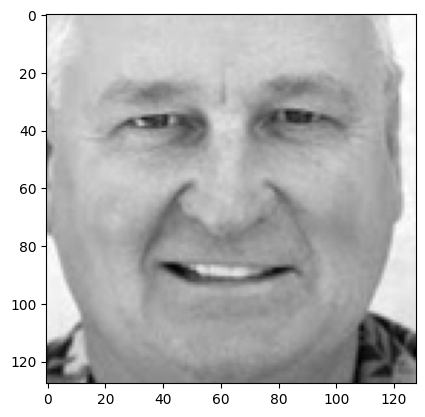

In [59]:
index=20
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')